In [1]:
import os
from tqdm import tqdm
from pathlib import Path
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from scatspectra import *
from scatspectra.layers import TimeAverage, WindowSelector

ILLUSTATION_PATH = Path(os.getcwd()) / "illustration"
ILLUSTATION_PATH.mkdir(exist_ok=True)

save = False
def save_figure(filename: str, dpi: int = 300):
    if save:
        plt.savefig(ILLUSTATION_PATH / filename, dpi=dpi, bbox_inches="tight")

CUDA = torch.cuda.is_available()  # Will automatically use GPU if available. Set it to False to force CPU

# Test of github repository

In [2]:
# CHECK ALL MODELS RUN
x = load_data(
    name="smrw",
    R=4,
    T=2**10,
    H=0.5,
    lam=0.3,
    gamma=1 / (2**6) / 256,
    K0=0.03,
    alpha=0.23,
    beta=0.23,
)
x = np.concatenate([x] * 4, axis=1)

for mtype in tqdm(
    [
        None,
        "scat_spectra",
        "inv_scat_spectra",
        "scat_marginal+scat_spectra",
        "scat_marginal",
    ]
):
    Rx = analyze(
        x.astype(np.float32),
        model_type=mtype,
        multivariate=False,
        J=6,
        normalize="each_ps",
        cuda=False,
        nchunks=2,
    )
    Rx = analyze(
        x.astype(np.float64),
        model_type=mtype,
        multivariate=False,
        J=6,
        normalize="each_ps",
        cuda=False,
    )
print("PASSED")

Model SMRW: generating data ...


100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Finished.


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

PASSED


In [3]:
# SCATTERING r > 2
x = load_data(
    name="smrw",
    R=1,
    T=2**8,
    H=0.5,
    lam=0.3,
    gamma=1/(2**6)/256,
    K0=0.03,
    alpha=0.23,
    beta=0.23,
)
x = np.concatenate([x]*15, axis=1)

Sx = analyze(x, model_type=None, J=8, normalize="each_ps", cuda=CUDA, r=3)
Rx = analyze(x, model_type="scat_marginal", J=8, normalize="each_ps", cuda=CUDA, r=3)

test1 = Sx.query(r=3, n=[10,11], j1=2, j2=4, j3=6).y.abs().mean(-1, keepdims=True)
test2 = Rx.query(r=3, n=[10,11], j1=2, j2=4, j3=6, q=1.0).y

print((test1 - test2).abs().sum())

Model SMRW: generating data ...


100%|██████████| 1/1 [00:00<00:00, 46.34it/s]

Finished.


tensor(0., dtype=torch.float64)


In [4]:
# SCATTERING TEST
T = 2**12

x = load_data(name="smrw", R=16, T=T, lam=0.1, H=0.5)
Sx1 = analyze(x, model_type=None, normalize="each_ps")
Sx2 = analyze(x, model_type=None, normalize="batch_ps")

Wx1 = Sx1.query(r=1).y
Wx2 = Sx2.query(r=1).y

print((Wx1.abs().pow(2.0).mean(-1) - 1.0).abs().sum())
print((Wx2.abs().pow(2.0).mean(-1).mean(0) - 1.0).abs().sum())

Model SMRW: generating data ...


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

Finished.


tensor(1.9207e-14, dtype=torch.float64)
tensor(1.3323e-15, dtype=torch.float64)


In [5]:
# DESCRIPTION TEST
x = load_data(
    name="smrw",
    R=32,
    T=2**12,
    H=0.5,
    lam=0.1,
    gamma=1/(2**12)/256,
    K0=0.03,
    alpha=0.23,
    beta=0.23,
)
Rx = analyze(x, J=8, model_type="scat_marginal+scat_spectra", normalize="each_ps")
Rx_real = format_to_real(Rx)

y1 = Rx.query(coeff_type="skewness", jr1=3, jl1=4).y
y2_c = Rx_real.query(coeff_type="skewness", jr1=3, jl1=4).y
y2 = y2_c[:, :1, :] + 1j * y2_c[:, 1:, :]

test = (y1 - y2).abs().sum()
print(test)

Model SMRW: generating data ...


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

Finished.


tensor(0., dtype=torch.float64)


In [6]:
# AVERAGING OPERATOR TEST (requires gpu with memory > 20Gb)
x = load_data(name="fbm", R=1, T=2**12, H=0.65).astype(np.float32)


class Pooling(nn.Module):
    def __init__(self, kernel_size):
        super(Pooling, self).__init__()
        self.pool = nn.AvgPool1d(kernel_size)

    def forward(self, x):
        y = self.pool(x.view(x.shape[0], -1, x.shape[-1]))
        return y.view(x.shape[:-1] + (-1,))


Rx = analyze(
    x,
    J=[7, 6, 6],
    Q=[6, 2, 2],
    r=3,
    model_type="scat_marginal",
    estim_operator=Pooling(kernel_size=16),
    cuda=CUDA,
)

print("PASSED")

Model fbm: generating data ...


100%|██████████| 1/1 [00:00<00:00, 17.08it/s]

Finished.


PASSED


In [7]:
# MARGINAL TEST
T = 2**12
J = 8

x = load_data(
    name="smrw",
    R=16,
    T=T,
    H=0.5,
    lam=0.1,
    gamma=1/T/256,
    K0=0.03,
    alpha=0.23,
    beta=0.23,
)
x = x.reshape(4, 4, -1)

Sx = analyze(x, model_type=None, J=J, cuda=False, nchunks=1)
Rx_mar = analyze(
    x,
    model_type="scat_marginal",
    J=J,
    normalize="each_ps",
    qs=[1.0, 2.0],
    cuda=False,
    nchunks=1,
)
Rx_covscat = analyze(
    x,
    model_type="scat_marginal+scat_spectra",
    J=J,
    normalize="each_ps",
    cuda=False,
    nchunks=1,
)

ps = Sx.query(n=2, r=1, is_low=False).y.abs().pow(2.0).mean(-1)[0, :]
moments_mar = Rx_mar.query(n=2, q=1.0, r=2, j1=2).y[0, :, 0]
Wx = Sx.query(n=2, r=2, j1=2)
moments_scat = Wx.y.abs().mean(-1)[0, :] / ps[2].pow(0.5)
moments_scat2 = Rx_covscat.query(coeff_type="scat_marginal", nl=2, jl1=2).y[0, :, 0]

print((moments_scat2 - moments_mar).abs().sum())
print((moments_scat - moments_scat2).abs().sum())

Model SMRW: generating data ...


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

Finished.


tensor(0., dtype=torch.float64)
tensor(8.3267e-17, dtype=torch.float64)


Model SMRW: generating data ...


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Finished.
tensor(1.0842e-19, dtype=torch.float64)
DONE


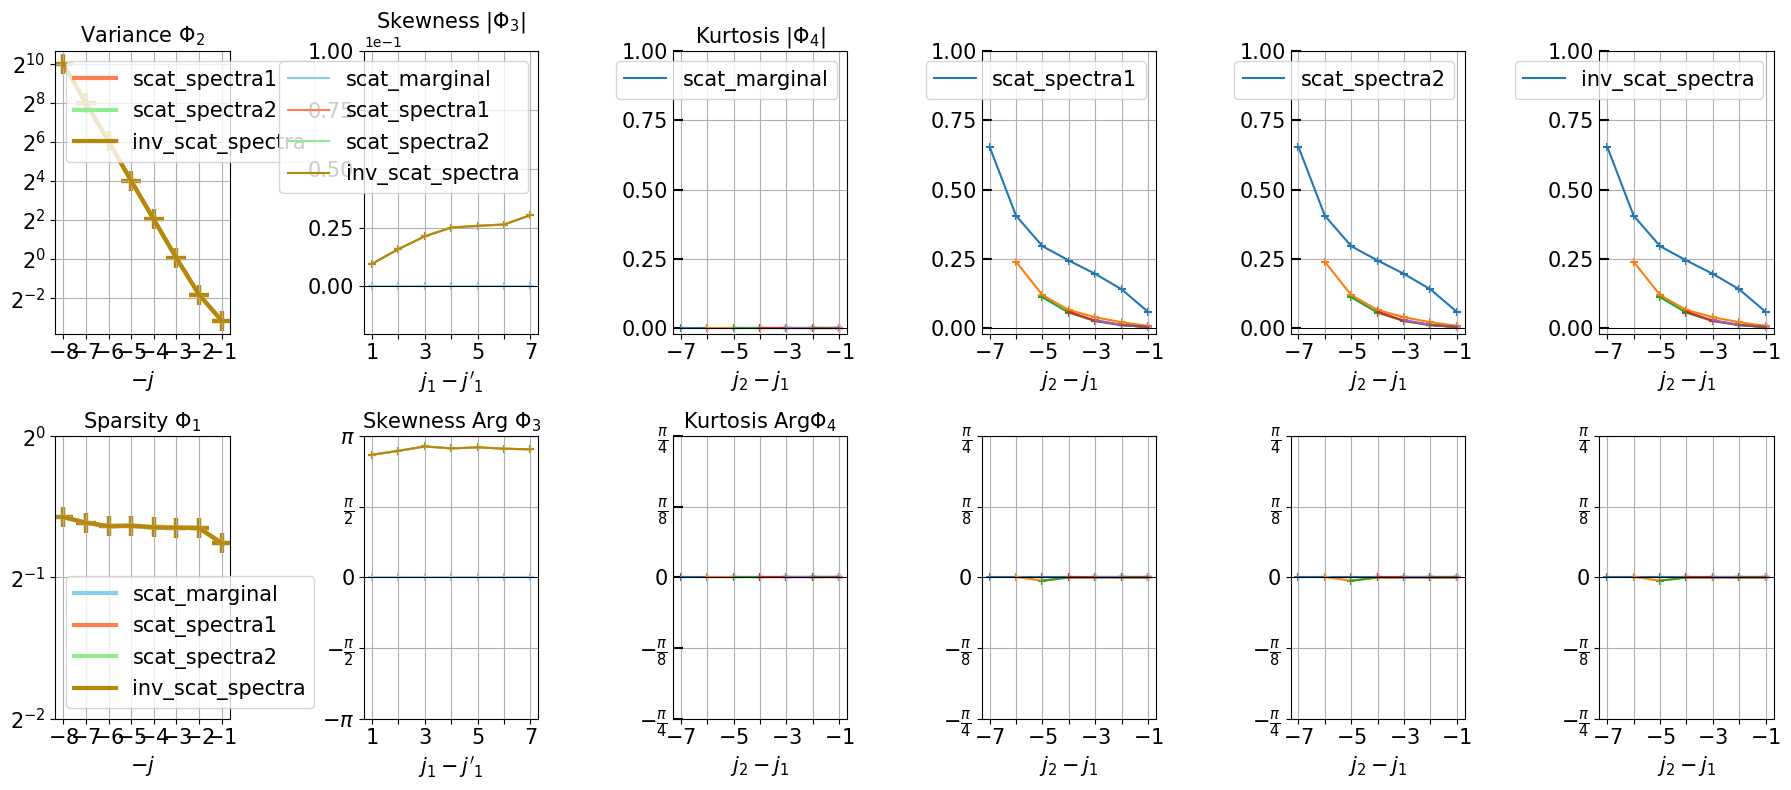

In [8]:
# ANALYSIS TEST
B = 128
T = 2**12
J = 8

x = load_data(
    name="smrw",
    R=B,
    T=T,
    H=0.5,
    lam=0.1,
    gamma=1/T/256,
    K0=0.03,
    alpha=0.23,
    beta=0.23,
)
Rx_scat = analyze(x, model_type="scat_marginal", J=J, cuda=False, nchunks=B)
Rx_cov1 = analyze(x, model_type="scat_spectra", J=J, cuda=False, nchunks=1)
Rx_cov2 = analyze(x, model_type="scat_spectra", J=J, cuda=False, nchunks=2*B)
Rx_covstat = analyze(
    x,
    model_type="inv_scat_spectra",
    J=J,
    normalize="batch_ps",
    cuda=CUDA,
    nchunks=B//2,
)
print((Rx_cov1.y - Rx_cov2.y).abs().sum())
print("DONE")
plot_dashboard(
    [Rx_scat, Rx_cov1, Rx_cov2, Rx_covstat],
    labels=["scat_marginal", "scat_spectra1", "scat_spectra2", "inv_scat_spectra"],
    fontsize=15,
);

In [9]:
# MULTI Q TEST
B = 1
T = 2**9

x = load_data(
    name="smrw",
    R=B,
    T=T,
    H=0.5,
    lam=0.1,
    gamma=1/T/256,
    K0=0.03,
    alpha=0.23,
    beta=0.23,
)
x = np.float32(x)
Rx_scat = analyze(
    x,
    model_type="scat_marginal",
    J=[5, 4],
    Q=[8, 16],
    wav_type=["battle_lemarie", "morlet"],
    cuda=CUDA,
    nchunks=1,
)
Rx_cov = analyze(
    x,
    model_type="scat_spectra",
    J=[5, 4],
    Q=[2, 4],
    wav_type=["battle_lemarie", "morlet"],
    cuda=CUDA,
    nchunks=1,
)
print("PASSED")

Model SMRW: generating data ...


100%|██████████| 1/1 [00:00<00:00, 29.21it/s]

Finished.


PASSED


In [12]:
# DIFFERENT ESTIMATORS (NUMERIC)
N = 25
T = 2**8
J = 6

x = load_data(
    name="smrw",
    R=1,
    T=T,
    H=0.5,
    lam=0.3,
    gamma=1/(2**6)/256,
    K0=0.03,
    alpha=0.23,
    beta=0.23,
)
x = np.concatenate([x] * N, axis=0)

ave1 = TimeAverage()
ave2 = WindowSelector(np.arange(T//4, 3*T//4))
ave3 = TimeAverage(np.arange(T//4, 3*T//4))

for mtype in [
    None,
    "scat_spectra",
    "inv_scat_spectra",
    "scat_marginal+scat_spectra",
    "scat_marginal",
]:
    Rx = analyze(
        x, model_type=mtype, J=J, normalize="each_ps", estim_operator=ave1, cuda=False
    )
    Rx = analyze(
        x, model_type=mtype, J=J, normalize="each_ps", estim_operator=ave2, cuda=False
    )
    Rx = analyze(
        x, model_type=mtype, J=J, normalize="each_ps", estim_operator=ave3, cuda=False
    )

Sx = analyze(x, model_type=None, J=J, qs=[2.0], cuda=False)
Rx1 = analyze(
    x, model_type="scat_marginal", J=J, qs=[2.0], estim_operator=ave2, cuda=False
)
Rx2 = analyze(
    x, model_type="scat_marginal", J=J, qs=[2.0], estim_operator=ave3, cuda=False
)

test1 = Sx.query(n=4, r=1).y.abs().pow(2.0)[..., T//4 : 3*T//4].mean(-1)
test2 = Rx1.query(q=2, n=4, r=1).y.mean(-1)
test3 = Rx2.query(q=2, n=4, r=1).y[:, :, 0]

print((test1 - test2).abs().sum())
print((test2 - test3).abs().sum())

Model SMRW: generating data ...


100%|██████████| 1/1 [00:00<00:00, 58.95it/s]

Finished.
(25, 1, 256)


tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)


In [13]:
# SELF-SIMILARITY SCORE
x = np.random.randn(128, 2**12)
Rx = analyze(x, J=6, normalize="batch_ps")

score_ref1, score1 = self_simi_obstruction_score(
    x, Rx=None, J=6, nchunks=64, cuda=CUDA
)
score_ref2, score2 = self_simi_obstruction_score(
    None, Rx=Rx.mean_batch(), J=6, nchunks=64, cuda=CUDA
)
score_ref3, score3 = self_simi_obstruction_score(
    None, Rx=Rx, J=6, nchunks=64, cuda=False
)
print("PASSED")

PASSED


Model SMRW: generating data ...


100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

Finished.


Initialize model
Model scat_spectra based on 239 statistics: 
 ---- mean : 1
 ---- spars : 9
 ---- variance : 10
 ---- skewness : 54
 ---- kurtosis : 165
Preparing target statistics
     4it in 0:00:00.23 ( 17.44 it/s ) .... err 1.84E+00
    12it in 0:00:00.42 ( 28.37 it/s ) .... err 3.06E-01
    25it in 0:00:00.71 ( 35.14 it/s ) .... err 1.26E-01
   144it in 0:00:03.65 ( 39.40 it/s ) .... err 2.21E-02
Optimization Exit Message : SmallEnoughException
matched statistics in 7.59s, 305 iterations -- 40.16it/s
    abs sqrt error 9.99E-03
    relative gradient error 7.03E-07
    loss0 1.95E+00
DONE


(-4.5, 4.5)

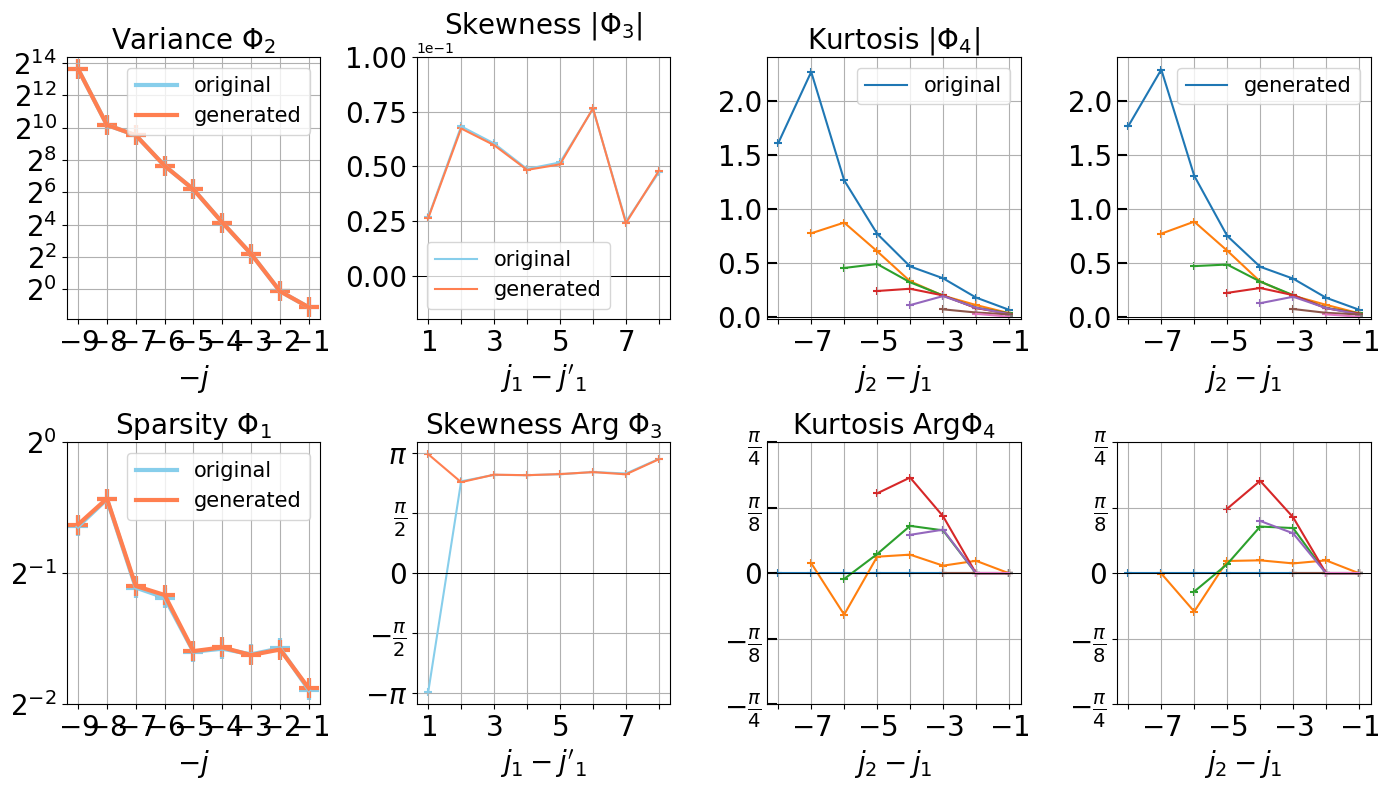

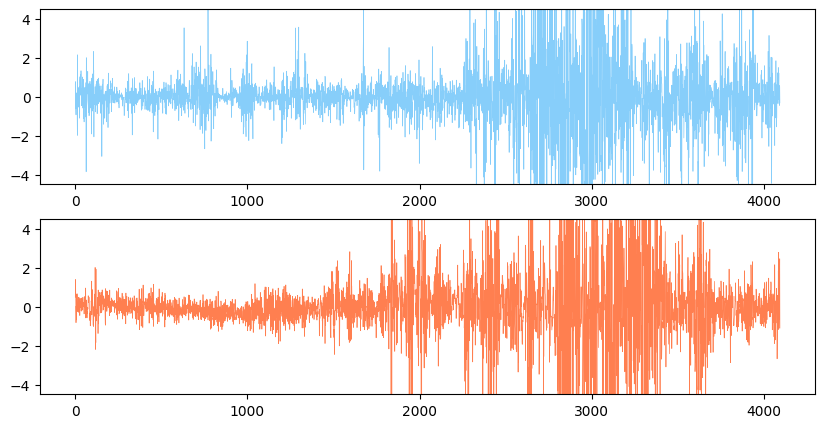

In [14]:
# GENERATION TEST (VISUAL)
B = 1
T = 2**12
J = 9
cache_path = (
    None  # set a path, e.g. Path("/home/<user>/_cache_path/"), to cache data generation
)

x = load_data(
    name="smrw",
    R=B,
    T=T,
    H=0.5,
    lam=0.3,
    gamma=1/T/256,
    K0=0.03,
    alpha=0.23,
    beta=0.23,
    cache_path=cache_path,
)
x_gen = generate(
    x,
    gen_log_returns=False,
    J=J,
    R=1,
    max_iterations=1000,
    cuda=CUDA,
    tol_optim=1e-2,
    cache_path=cache_path,
)
print("DONE")

Rx = analyze(x, model_type="scat_spectra", J=J, cuda=CUDA, nchunks=1)
Rx_gen = analyze(x_gen.lnx, model_type="scat_spectra", J=J, cuda=CUDA, nchunks=1)
plot_dashboard([Rx, Rx_gen], labels=["original", "generated"])

# VISUALIZATION
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(np.diff(x)[0, 0, :], color="lightskyblue", linewidth=0.5)
axes[1].plot(x_gen.dlnx[0, 0, :], color="coral", linewidth=0.5)
axes[0].set_ylim(-4.5, 4.5)
axes[1].set_ylim(-4.5, 4.5)

# Github README

Model fbm: generating data ...


100%|██████████| 4/4 [00:00<00:00, 10.44it/s]


Finished.
Model MRW: generating data ...


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Finished.
0.5301487205928218
0.42594148121053443
55.99398850825079


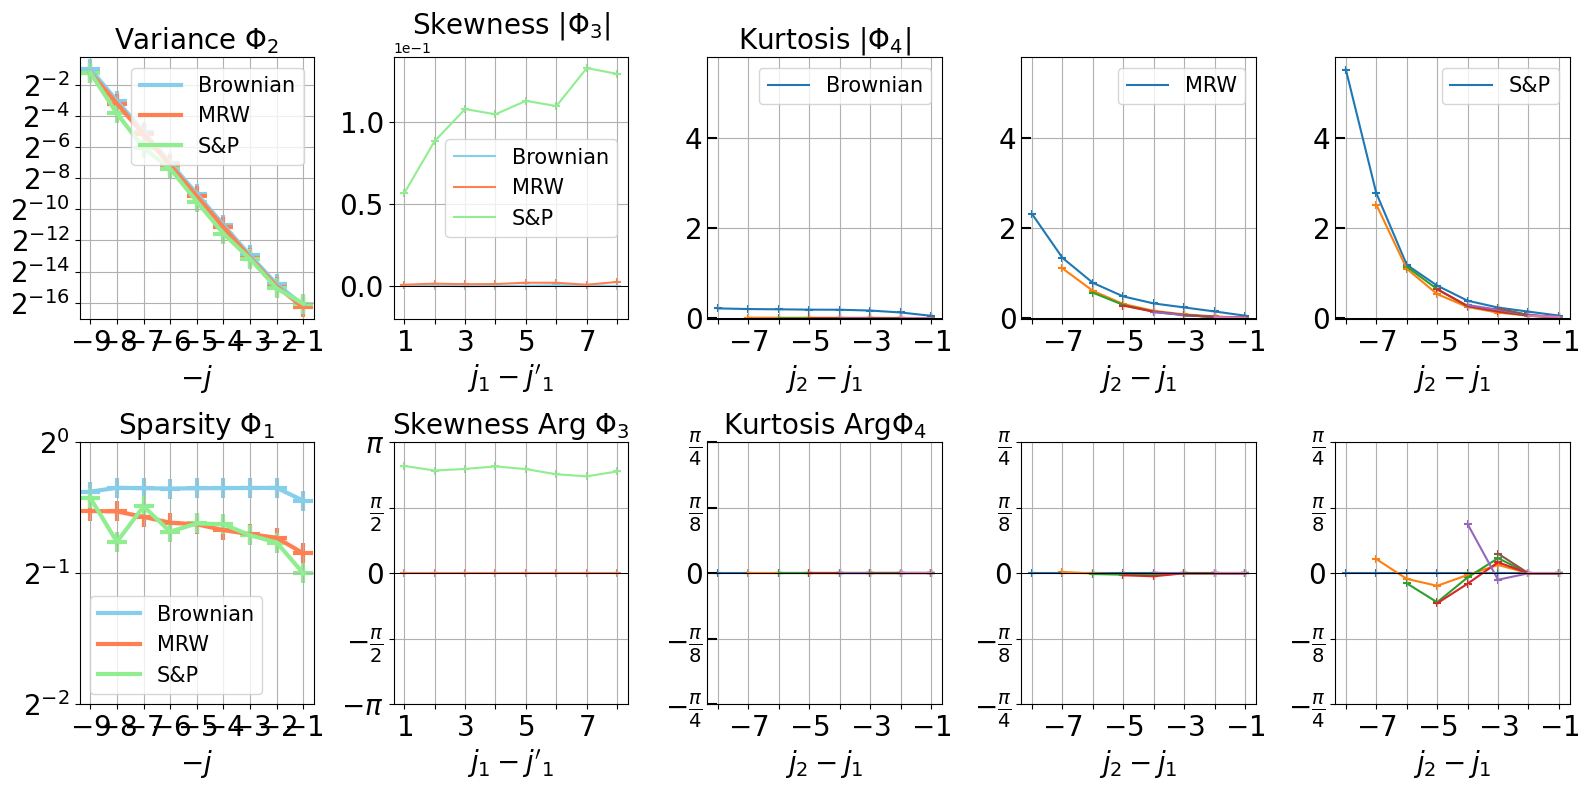

In [3]:
save = True

from scatspectra import load_data, SPDaily, analyze, plot_dashboard

# DATA
x_brownian = load_data(name='fbm', R=256, T=6063, H=0.5)
x_mrw = load_data(name='mrw', R=256, T=6063, H=0.5, lam=0.2)
x_snp = SPDaily().lnx  # S&P500 daily prices from 2000 to 2024

# ANALYSIS
scat_brownian = analyze(x_brownian)
scat_mrw = analyze(x_mrw)
scat_snp = analyze(x_snp)

# VISUALIZATION
plot_dashboard([scat_brownian, scat_mrw, scat_snp], labels=['Brownian', 'MRW', 'S&P']);

for x in [x_brownian, x_mrw, x_snp]:
    print((x**2).mean())

save_figure("dashboard_brown_mrw_snp.png")

## Self-similarity section

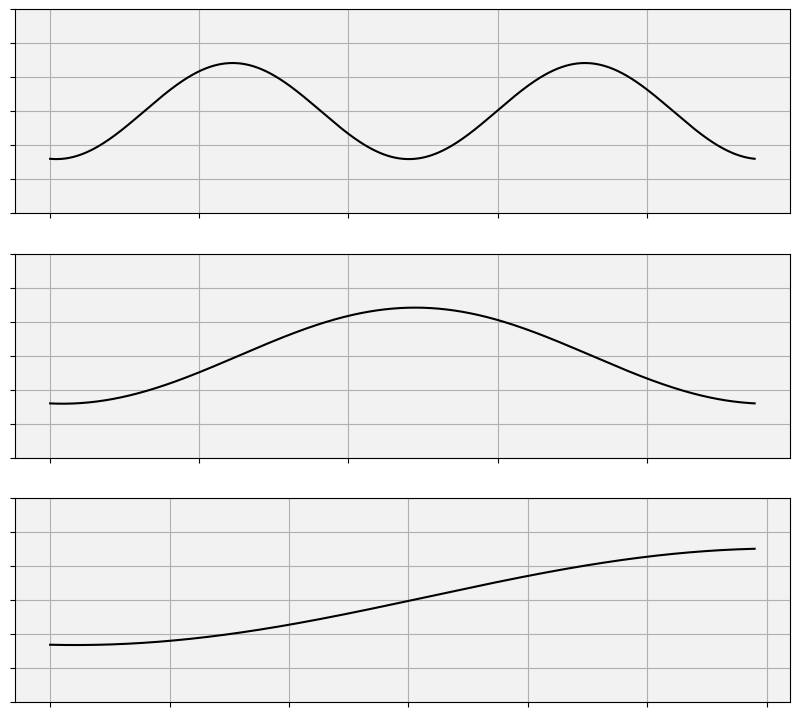

In [8]:
# not self-similar example
T = 4724
np.random.seed(8)

ts = np.linspace(0, 2*np.pi, T)
ts = np.roll(ts, -3500)

r = 3
a = np.random.choice(T, r, replace=False)
b = np.random.randn(r)

eia = [np.exp(2*np.pi * t/T * 1j) for t in a]
P = scipy.interpolate.lagrange(eia, b)


def x(t):
    #     return np.real(P(np.cos(t) + 1j * np.sin(t))) # general smooth function
    return np.cos(2 * t)  # fourier vector


# sees 3 dilated at once
ys = []
for j in range(3):
    y = x(ts[:T//(2**j)])
    ys.append(y)

fig, axes = plt.subplots(3, figsize=(10, 9))
for ax, y in zip(axes.ravel(), ys):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_facecolor(tuple(0.95 for _ in range(3)))
    ax.grid(None)
    y -= y.mean()
    y /= y.std()
    ax.plot(np.arange(y.size), y, color="black")
    ax.set_ylim(-3.0, 3.0)

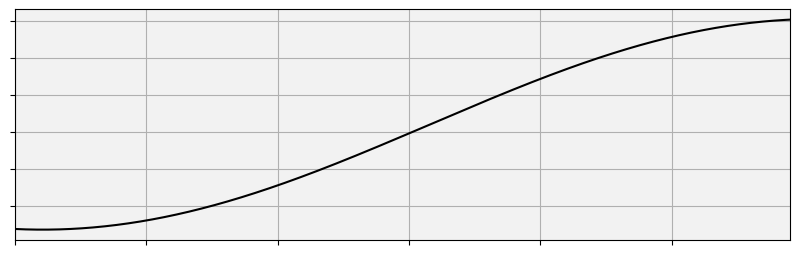

In [9]:
save = False
i = 2

plt.figure(figsize=(10, 3))
plt.plot(ys[i], color="black")
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_facecolor((0.95,)*3)
ax.grid(None)
ax.set_xlim(0, ys[i].size - 1)
save_figure(f"not_self_similar_{i}.png")

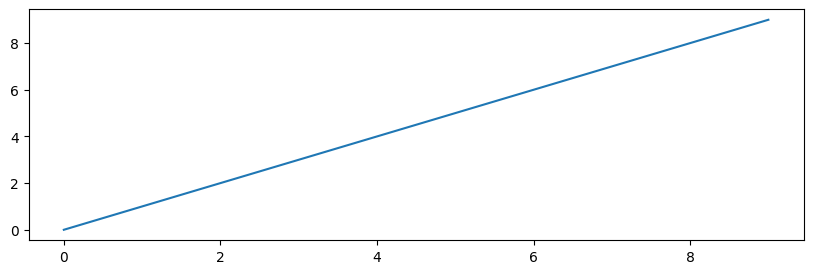

In [10]:
plt.figure(figsize=(10, 3))
plt.plot(np.arange(10))

In [11]:
x2 = np.stack([x(np.roll(ts, shift)) for shift in np.arange(T//2)])[:, None, :]
print(x2.shape)
self_simi_obstruction_score(x2, J=8, nchunks=128, cuda=CUDA)

(2362, 1, 4724)


({'spars': array([0.43906769]),
  'variance': array([0.12965254]),
  'skewness': array([0.00341717]),
  'kurtosis': array([0.06035118]),
  'total': array([0.63248858])},
 {'spars': array([1.02397804]),
  'variance': array([5.67961575]),
  'skewness': array([5.40397278e-07]),
  'kurtosis': array([0.30572324]),
  'total': array([7.00931756])})

## Generation

Initialize model
Model scat_spectra based on 239 statistics: 
 ---- mean : 1
 ---- spars : 9
 ---- variance : 10
 ---- skewness : 54
 ---- kurtosis : 165
Preparing target statistics
     3it in 0:00:00.25 ( 12.05 it/s ) .... err 2.10E-01
    18it in 0:00:00.62 ( 29.06 it/s ) .... err 9.37E-02
   110it in 0:00:02.90 ( 37.90 it/s ) .... err 1.66E-02
Optimization Exit Message : SmallEnoughException
matched statistics in 5.41s, 206 iterations -- 38.09it/s
    abs sqrt error 5.98E-03
    relative gradient error 2.48E-04
    loss0 2.07E-01


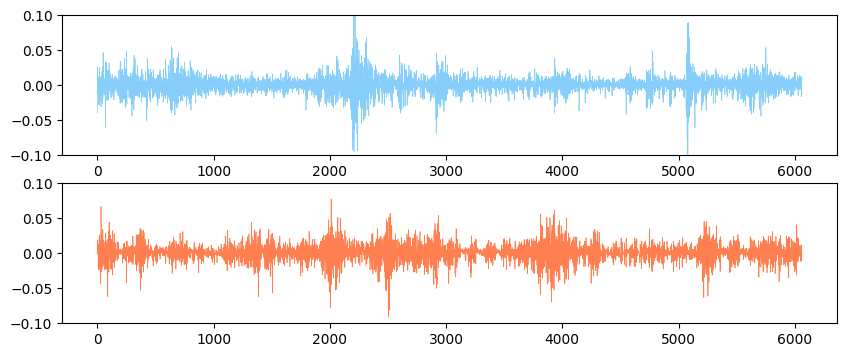

In [4]:
save = True

from scatspectra import generate

# DATA
snp_data = SPDaily()

# GENERATION
gen_data = generate(snp_data, cuda=CUDA, tol_optim=6e-3)

# VISUALIZATION
fig, axes = plt.subplots(2, 1, figsize=(10, 4))
axes[0].plot(snp_data.dlnx[0, 0, :], color="lightskyblue", linewidth=0.5)
axes[1].plot(gen_data.dlnx[0, 0, :], color="coral", linewidth=0.5)
axes[0].set_ylim(-0.1, 0.1)
axes[1].set_ylim(-0.1, 0.1)

save_figure("generation.png")